# Taco Dataset for testing the best model

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os



TACO_ROOT = '../TACO/data' 

TACO_ANNOTATIONS = '../TACO/data/annotations.json' 

MODEL_PATHS = {
    'Baseline': '../best_model/best_resnet50_baseline.pth',
    'Augmented': '../best_model/best_resnet50_augmented.pth',
    'CutMix': '../best_model/best_resnet50_cutmix.pth'
}

CLASS_MAP = {0: 'Cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Configuration Set. Using device: {DEVICE}")

✅ Configuration Set. Using device: cuda


In [ ]:
class TacoTestDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = [] 

        self.taco_map = {
            # Cardboard (0)
            'Cardboard': 0, 'Carton': 0, 'Corrugated carton': 0, 'Pizza box': 0, 
            'Drink carton': 0, 'Egg carton': 0, 'Toilet tube': 0,
            # Glass (1)
            'Glass bottle': 1, 'Broken glass': 1, 'Glass jar': 1,
            # Metal (2)
            'Aluminium foil': 2, 'Drink can': 2, 'Food can': 2, 'Metal bottle cap': 2, 
            'Aerosol': 2, 'Scrap metal': 2, 'Pop tab': 2, 'Metal lid': 2,
            # Paper (3)
            'Paper': 3, 'Paper bag': 3, 'Newspaper/magazine': 3, 'Scrap paper': 3, 
            'Notebook': 3, 'Receipt': 3, 'Paper cup': 3,
            # Plastic (4)
            'Clear plastic bottle': 4, 'Other plastic bottle': 4, 'Plastic bottle cap': 4, 
            'Plastic lid': 4, 'Plastic straw': 4, 'Plastic bag & wrapper': 4, 'Polystyrene': 4, 
            'Plastic cup': 4, 'Disposable plastic cup': 4, 'Tupperware': 4, 'Squeezable tube': 4, 
            'Plastic film': 4, 'Six pack rings': 4, 'Garbage bag': 4, 'Plastic utensils': 4
        }

        # Load Annotations
        with open(annotation_file, 'r') as f:
            data = json.load(f)

        cats = {c['id']: c['name'] for c in data['categories']}
        imgs = {i['id']: (i['file_name'], i['width'], i['height']) for i in data['images']}

        # Filter valid images
        for ann in data['annotations']:
            cat_name = cats[ann['category_id']]
            if cat_name in self.taco_map:
                target = self.taco_map[cat_name]
                
                # Get Image Info
                img_name, img_w, img_h = imgs[ann['image_id']]
                img_path = self.root_dir / img_name
                
                bbox = ann['bbox'] 
                x, y, w, h = bbox

                if w < 60 or h < 60:
                    continue
                            
                if w <= 1 or h <= 1:
                    continue
                    
                if x >= img_w or y >= img_h:
                    continue

                if img_path.exists():
                    self.samples.append((str(img_path), bbox, target))

        print(f"TACO Dataset initialized: Found {len(self.samples)} valid samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, bbox, label = self.samples[idx]
        
        image = Image.open(path).convert('RGB')
        img_w, img_h = image.size

        x, y, w, h = bbox
        
        center_x = x + w / 2
        center_y = y + h / 2
        max_dim = max(w, h) * 1.2 
        
        new_w = max_dim
        new_h = max_dim
        
        left = int(center_x - new_w / 2)
        top = int(center_y - new_h / 2)
        right = int(center_x + new_w / 2)
        bottom = int(center_y + new_h / 2)
        

        left = max(0, min(left, img_w - 1))
        top = max(0, min(top, img_h - 1))
        right = max(left + 1, min(right, img_w))     
        bottom = max(top + 1, min(bottom, img_h))   

        crop = image.crop((left, top, right, bottom))
        
        if self.transform:
            crop = self.transform(crop)
        
        return crop, label

In [9]:
def load_model(path, model_name):
    print(f"Loading {model_name} from {path}...")
    
    model = models.resnet50(weights=None) 
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 5)
    )
    
    try:
        checkpoint = torch.load(path, map_location=DEVICE)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
    except Exception as e:
        print(f"❌ ERROR loading {model_name}: {e}")
        return None
        
    model = model.to(DEVICE)
    model.eval()
    return model

def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

In [10]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


taco_dataset = TacoTestDataset(TACO_ROOT, TACO_ANNOTATIONS, transform=test_transforms)
taco_loader = DataLoader(taco_dataset, batch_size=32, shuffle=False)

results = {}

print("\nStarting Evaluation on TACO (Real World Data)...")
print("-" * 50)

for name, path in MODEL_PATHS.items():
    if not os.path.exists(path):
        print(f"⚠️ SKIPPING {name}: File not found at {path}")
        results[name] = 0.0
        continue
        
    model = load_model(path, name)
    
    if model:
        acc = evaluate_model(model, taco_loader)
        results[name] = acc
        print(f"{name} Accuracy: {acc:.2f}%")
        
        del model
        torch.cuda.empty_cache()

print("-" * 50)
print("✅ Evaluation Complete.")

TACO Dataset initialized: Found 2000 valid samples.

Starting Evaluation on TACO (Real World Data)...
--------------------------------------------------
Loading Baseline from ../best_model/best_resnet50_baseline.pth...
Baseline Accuracy: 47.20%
Loading Augmented from ../best_model/best_resnet50_augmented.pth...
Augmented Accuracy: 52.10%
Loading CutMix from ../best_model/best_resnet50_cutmix.pth...
CutMix Accuracy: 55.20%
--------------------------------------------------
✅ Evaluation Complete.


✅ Saved clean visualization to ../plots/taco_samples.png


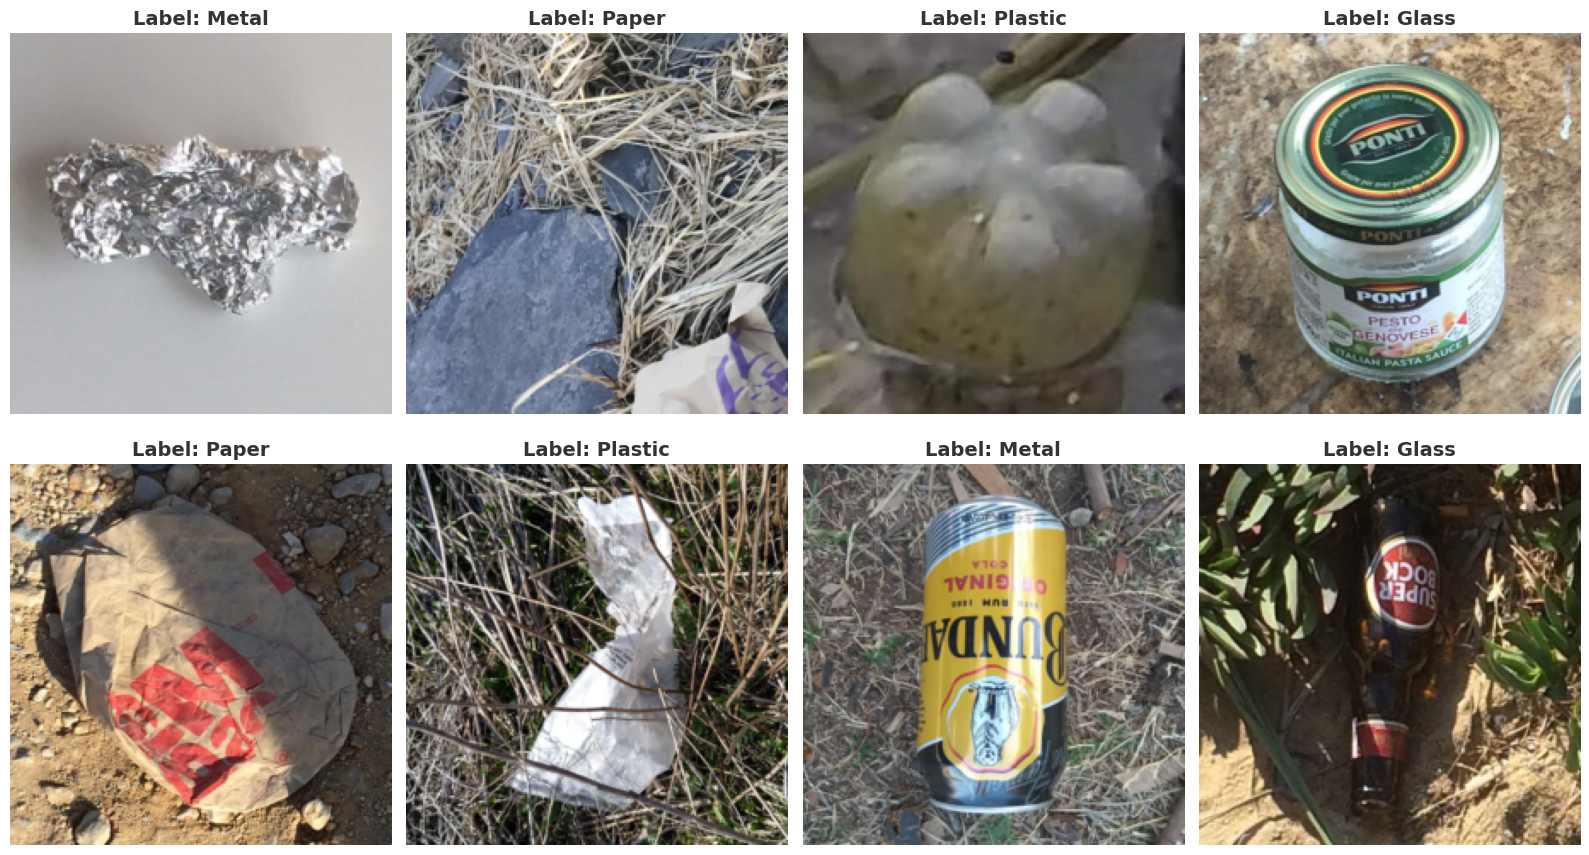

In [11]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def show_taco_batch(dataset, num_samples=8):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 9))
    axes = axes.flatten() 
    
    class_names = {v: k for k, v in dataset.taco_map.items()} 
 
    display_names = {0: 'Cardboard', 1: 'Glass', 2: 'Metal', 3: 'Paper', 4: 'Plastic'}

    for i in range(num_samples):
        ax = axes[i]
        
        img = images[i].numpy().transpose((1, 2, 0))
        img = STD * img + MEAN
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        label_idx = labels[i].item()
        class_name = display_names.get(label_idx, 'Unknown')
        
        ax.set_title(f"Label: {class_name}", fontsize=14, fontweight='bold', color='#333333')
        ax.axis('off')

    plt.tight_layout()
    save_path = '../plots/taco_samples.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✅ Saved clean visualization to {save_path}")
    plt.show()

show_taco_batch(taco_dataset)

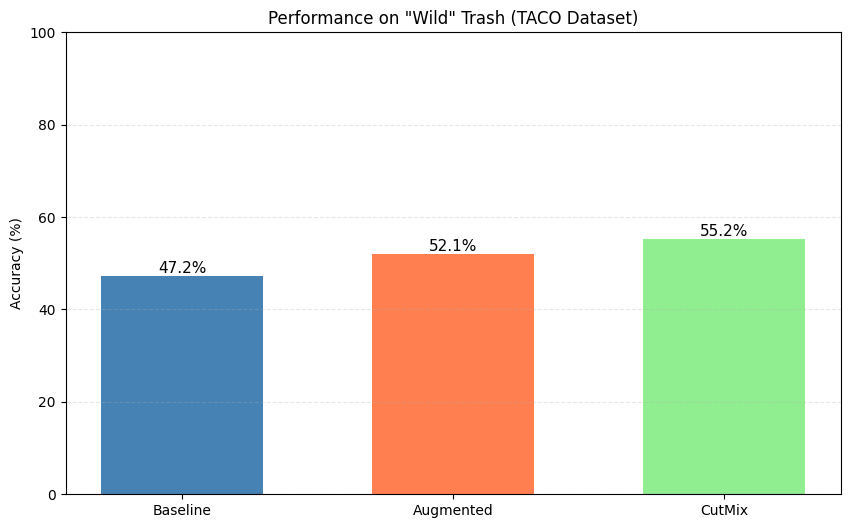

In [12]:
names = list(results.keys())
accuracies = list(results.values())

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ['steelblue', 'coral', 'lightgreen']
bars = ax.bar(names, accuracies, color=colors, width=0.6)

ax.set_ylabel('Accuracy (%)')
ax.set_title('Performance on "Wild" Trash (TACO Dataset)')
ax.set_ylim([0, 100])
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11)

save_path = '../plots/taco_accuracies.png'
plt.savefig(save_path, bbox_inches='tight', dpi=150)

plt.show()